# Benchmark - Using VadarSentiment

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 10.4MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Example
score = analyser.polarity_scores("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.")
print(score)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


# Using LSTM model trained on IMDB dataset from tensorflow

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete39C8H7/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete39C8H7/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete39C8H7/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Vocabulary size: 8185
Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."
4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .
Epoch 1/10
391/391 [==============================] - 273s 609ms/step - loss: 0.6873 - accuracy: 0.5071 - val_loss: 0.4650 - val_accuracy: 0.7719
Epoch 2/10
391/391 [==============================] - 234s 598ms/step - loss: 0.3970 - accuracy: 0.8309 - val_loss: 0.3537 - val_accuracy: 0.8620
Epoch 3/10
391/391 [==============================] - 239s 611ms/step - loss: 0.2737 - accuracy: 0.9010 - val_loss: 0.3782 - val_accuracy: 0.8615
Epoch 4/10
391/391 [==============================] - 238s 609ms/step - loss: 0.2256 - accuracy: 0.9206 - val_loss: 0.3526 - val_accuracy: 0.8526
Epoch 5/10
391/391 [=============================

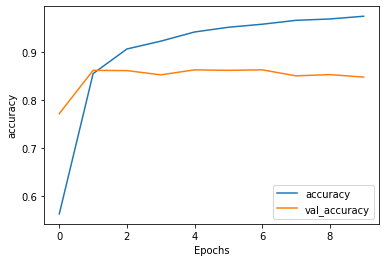

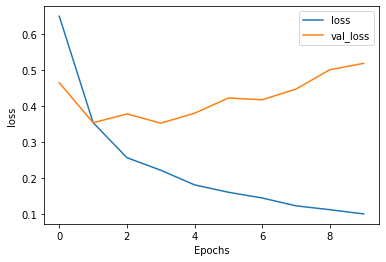

In [ ]:

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

'''
REFERENCES:
https://www.tensorflow.org/tutorials/text/text_classification_rnn
and external runable version
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb#scrollTo=hw86wWS4YgR2
'''

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

encoder = info.features['text'].encoder

print('Vocabulary size: {}'.format(encoder.vocab_size))

sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

assert original_string == sample_string

for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, ([-1],[]))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, ([-1],[]))

def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Change epochs to 10 to reduce overfitting

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')




## Predict an example news using the trained model

In [ ]:
new_prediction = sample_predict("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.", pad=True)
print(new_prediction)

new_prediction = sample_predict("Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow.", pad=False)
print(new_prediction)


[[1.0463964]]
[[-0.6433579]]


# Building a Neural Network 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras import models, layers,  regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from nltk import word_tokenize

In [ ]:
def vectorize(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
  
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

x_train  (40000, 10000)
x_test  (10000, 10000)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                500050    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout

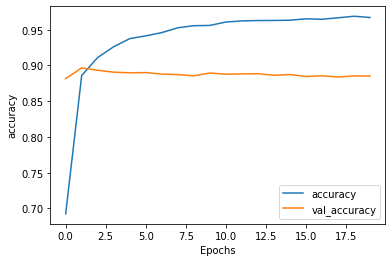

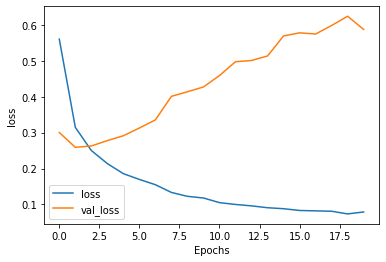

In [ ]:
(training_data, training_label), (test_data, test_label) = imdb.load_data(num_words=10000, index_from=3)

data = np.concatenate((training_data, test_data), axis=0)
targets = np.concatenate((training_label, test_label), axis=0)
data = vectorize(data)
targets = np.array(targets).astype("float32")
x_test = data[:10000]
test_label = targets[:10000]
x_train = data[10000:]
training_label = targets[10000:]

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

#training_label = np.array(training_label).astype("float32")
#test_label = np.array(test_label).astype("float32")


model = models.Sequential()
model.add(layers.Dense(50,activation = "relu", input_shape=(10000, )))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

#model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])


history = model.fit(x_train, training_label, epochs=20, batch_size=512, validation_data=(x_test,test_label))

test_loss, test_acc = model.evaluate(x_test, test_label)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Data preprocessing

In [ ]:
TOP_WORDS = 10000

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
word2index = imdb.get_word_index()
word2index = {k:(v+3) for k,v in word2index.items()}
#word_to_id["<PAD>"] = 0
#word_to_id["<START>"] = 1
#word_to_id["<UNK>"] = 2

import string
# Tweet preprocessing
def clean_symbols(text):
    
    for char in text:
        # remove punctuation but preserve symbols defined above 
        if char in string.punctuation and char != ' ':
            text = text.replace(char, '')
        # remove all other characters
        if char.isalpha() is False and char.isdigit() is False and char != ' ':
            text = text.replace(char, '')
          
    return ' '.join(text.split())

def clean_words(news, dimension = TOP_WORDS):
  cleaned = clean_symbols(news).lower()
  test=[]
  for word in word_tokenize(cleaned):
    if word in word2index:
      test.append(word2index[word])
    
  results = np.zeros(dimension)
  for _ , sequence in enumerate(test):
    if sequence < dimension:
      results[sequence] = 1
    
  print("\nOriginal string:", news,"\n")
  print("\nIndex conversion:", test,"\n")
  results = np.reshape(results,(1, TOP_WORDS))
  print("\nConvert to vectors:", results,"\n")
  return results


      

In [ ]:


example_1 = "The movie was not good. The animation and the graphics were terrible. I would not recommend this movie."
example_2 = "it is so good"
example_3 = "Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow."
def predict_sentiment(x_test):

  x_test = clean_words(x_test, dimension = TOP_WORDS)
  print(x_test.shape)
  prediction = model.predict(x_test) 
  print(prediction)

In [ ]:
predict_sentiment(example_3)


Original string: Apple Stock Is Falling Again. Why That’s Not a Problem for the Dow. 


Index conversion: [7695, 2053, 9, 1454, 174, 138, 1584, 24, 6, 439, 18, 4] 


Convert to vectors: [[0. 0. 0. ... 0. 0. 0.]] 

(1, 10000)
[[0.0053616]]
